In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error

# pip install catboost xgboost lightgbm
# pip install numpy<2 
# TODO
from catboost import CatBoostRegressor ## 카테고리형태로 된거에 좋음
from xgboost import XGBRegressor       ## ??
from lightgbm import LGBMRegressor     ## ??

## 데이터 불러오기

In [2]:
df = pd.read_csv("data/housing.csv")

## 데이터 전처리

### NA 중위값 처리

In [3]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [4]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_6492\1590527289.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


<Axes: >

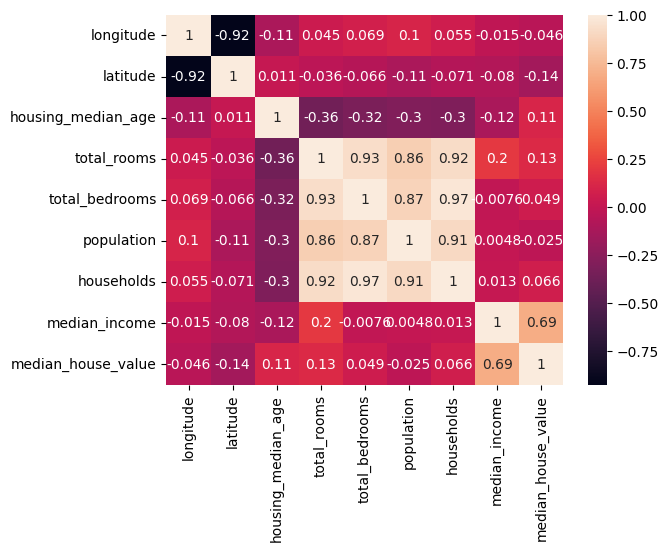

In [5]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

<Axes: xlabel='median_house_value', ylabel='Count'>

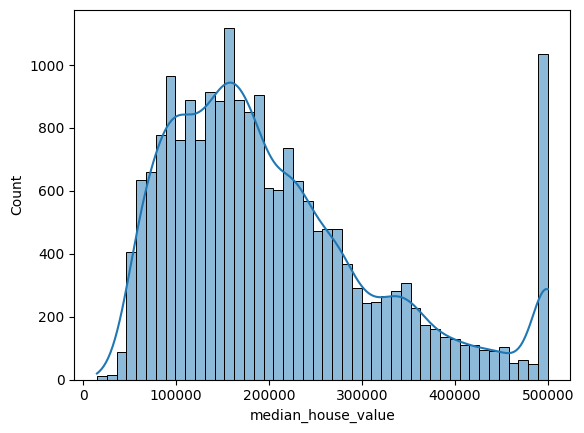

In [6]:
sns.histplot(df['median_house_value'], kde=True)

In [7]:
df['median_house_value'].skew() #0.6은 0.9를 넘어가면 심함

0.9777632739098341


## 특성 속성이 과도한 지표를 형성하고 있어서, 정리

In [8]:
df['bed_per_room'] = df['total_bedrooms'] / df['total_rooms']

## 데이터가 한쪽으로 치우쳐져 있는지 확인 후 정리

In [9]:
df['median_house_value'].skew() #0.6은 0.9를 넘어가면 심함

0.9777632739098341

In [10]:
X = df.drop(['median_house_value'], axis=1)
y = np.log(df['median_house_value'])

In [11]:
from scipy.stats import skew
skew_df = pd.DataFrame(X.select_dtypes(np.number).columns, columns=["Feature"])
skew_df["Skew"] = skew_df["Feature"].apply(lambda feature: skew(df[feature]))
skew_df["ABS_Skew"] = skew_df["Skew"].apply(abs)
skew_df["Skewed"] = skew_df["ABS_Skew"].apply(lambda x: True if x > 0.5 else False)
skew_df
# median_house_value 값이 너무 눌려있음

,Feature,Skew,ABS_Skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,4.147042,4.147042,True
4,total_bedrooms,3.480888,3.480888,True
5,population,4.935500,4.935500,True
6,households,3.410190,3.410190,True
7,median_income,1.646537,1.646537,True
8,bed_per_room,6.316445,6.316445,True


In [12]:
skew_col = skew_df[skew_df["ABS_Skew"] > 0.5]["Feature"].values
skew_col

array(['total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'bed_per_room'], dtype=object)

In [13]:
for col in skew_col:
    X[col] = np.log(X[col])

In [14]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bed_per_room
0,-122.23,37.88,41.0,6.779922,4.859812,5.774552,4.836282,2.119287,NEAR BAY,-1.920110
1,-122.22,37.86,21.0,8.867709,7.008505,7.783641,7.037028,2.116424,NEAR BAY,-1.859204
2,-122.24,37.85,52.0,7.290975,5.247024,6.206576,5.176150,1.982022,NEAR BAY,-2.043951
3,-122.25,37.85,52.0,7.149917,5.459586,6.324359,5.389072,1.730434,NEAR BAY,-1.690331
4,-122.25,37.85,52.0,7.394493,5.634790,6.336826,5.556828,1.347086,NEAR BAY,-1.759704
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,7.417580,5.924256,6.739337,5.799093,0.444878,INLAND,-1.493325
20636,-121.21,39.49,18.0,6.546785,5.010635,5.874931,4.736198,0.938756,INLAND,-1.536150
20637,-121.22,39.43,17.0,7.720462,6.184149,6.914731,6.070738,0.530628,INLAND,-1.536313
20638,-121.32,39.43,18.0,7.528332,6.013715,6.608001,5.855072,0.624440,INLAND,-1.514617


### 문자열을 숫자로 변경

In [15]:
encoder = LabelEncoder()
X['ocean_proximity'] = encoder.fit_transform(X['ocean_proximity'])

In [16]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bed_per_room
0,-122.23,37.88,41.0,6.779922,4.859812,5.774552,4.836282,2.119287,3,-1.920110
1,-122.22,37.86,21.0,8.867709,7.008505,7.783641,7.037028,2.116424,3,-1.859204
2,-122.24,37.85,52.0,7.290975,5.247024,6.206576,5.176150,1.982022,3,-2.043951
3,-122.25,37.85,52.0,7.149917,5.459586,6.324359,5.389072,1.730434,3,-1.690331
4,-122.25,37.85,52.0,7.394493,5.634790,6.336826,5.556828,1.347086,3,-1.759704
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,7.417580,5.924256,6.739337,5.799093,0.444878,1,-1.493325
20636,-121.21,39.49,18.0,6.546785,5.010635,5.874931,4.736198,0.938756,1,-1.536150
20637,-121.22,39.43,17.0,7.720462,6.184149,6.914731,6.070738,0.530628,1,-1.536313
20638,-121.32,39.43,18.0,7.528332,6.013715,6.608001,5.855072,0.624440,1,-1.514617


## 데이터 분리

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## 분류기 모음

In [18]:
lr = LinearRegression()
lr.fit(X_train,y_train)
predict_lr = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_lr))
r2 = r2_score(y_test, predict_lr)
print(rmse, r2)

0.3444038157651874 0.6345457124333707


In [19]:
Knn = KNeighborsRegressor()
Knn.fit(X_train,y_train)
predict_Knn = Knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_Knn))
r2 = r2_score(y_test, predict_Knn)
print(rmse, r2)
#선형값 이기기 쉽지 않다 이거야

0.3244770405871314 0.6756117632134155


In [20]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
predict_rf = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_rf))
r2 = r2_score(y_test, predict_rf)
print(rmse, r2)
# 그래도 r2값이 문제다 1에 가까울수록 좋은데
# 혹시 과적합으로 가는건가....? 혹시 성능이 좋아지는거야.....?

0.23336039978058004 0.8322156411450816


In [21]:
cat = CatBoostRegressor()
cat.fit(X_train,y_train)
predict_cat = cat.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_cat))
r2 = r2_score(y_test, predict_cat)
print(rmse, r2)
##확실히 rmse값이 떨어지면 r2(상관계수)가 올라간다
## rmse값은 점들간의 거리의 평균치

Learning rate set to 0.063766
0:	learn: 0.5477066	total: 120ms	remaining: 2m
1:	learn: 0.5272182	total: 122ms	remaining: 1m 1s
2:	learn: 0.5082013	total: 124ms	remaining: 41.3s
3:	learn: 0.4912890	total: 127ms	remaining: 31.5s
4:	learn: 0.4750285	total: 129ms	remaining: 25.8s
5:	learn: 0.4605128	total: 132ms	remaining: 21.8s
6:	learn: 0.4475175	total: 134ms	remaining: 19s
7:	learn: 0.4353580	total: 136ms	remaining: 16.8s
8:	learn: 0.4240331	total: 138ms	remaining: 15.2s
9:	learn: 0.4146684	total: 140ms	remaining: 13.8s
10:	learn: 0.4052256	total: 142ms	remaining: 12.7s
11:	learn: 0.3969183	total: 145ms	remaining: 11.9s
12:	learn: 0.3896859	total: 147ms	remaining: 11.2s
13:	learn: 0.3833644	total: 150ms	remaining: 10.6s
14:	learn: 0.3761449	total: 152ms	remaining: 10s
15:	learn: 0.3707153	total: 154ms	remaining: 9.5s
16:	learn: 0.3645221	total: 156ms	remaining: 9.04s
17:	learn: 0.3598349	total: 159ms	remaining: 8.67s
18:	learn: 0.3544757	total: 162ms	remaining: 8.36s
19:	learn: 0.350463

In [22]:
xg = XGBRegressor()
xg.fit(X_train,y_train)
predict_xg = xg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_xg))
r2 = r2_score(y_test, predict_xg)
print(rmse, r2)

0.23215147603571726 0.833949552238219


In [23]:
lgb = LGBMRegressor()
lgb.fit(X_train,y_train)
predict_lgb = lgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_lgb))
r2 = r2_score(y_test, predict_lgb)
print(rmse, r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 10
[LightGBM] [Info] Start training from score 12.086494
0.23079958378806373 0.8358778509571465


In [24]:
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
predict_gb = gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predict_gb))
r2 = r2_score(y_test, predict_gb)
print(rmse, r2)

0.2677920384520924 0.7790507789808199


In [25]:
f_predict = (
    0.25 * predict_cat +
    0.25 * predict_lgb +
    0.25 * predict_rf +
    0.25 * predict_xg
)

In [26]:
rmse = np.sqrt(mean_squared_error(y_test, f_predict))
r2 = r2_score(y_test, f_predict)
print(rmse, r2)

0.22011216024847488 0.8507256376539392
